In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro

import arviz as az

import random
import time

sns.set_style("darkgrid")

In [2]:
def toy_data(a ,b ,N):
    x = np.linspace(-1,1,N)
    y = a * x + b  + 1.0*jax.random.normal(jax.random.PRNGKey(1), x.shape)
    return x, y

In [3]:
x, y = toy_data(-5, 3, 50)

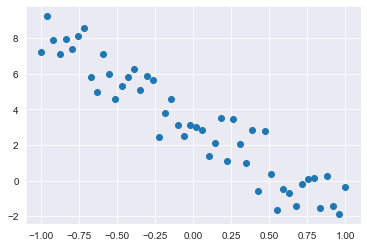

In [4]:
plt.scatter(x,y)

# Numpyro

In [5]:
def model_numpyro(x, y, N=100):
    
    ## 回帰係数 a、切片項 b の事前分布に平均0, 分散100の正規分布を置きます。
    a = numpyro.sample("a",
                     numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))
    b = numpyro.sample("b",
                     numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))

    ## 分散パラメータ sigma の事前分布に平均0, 分散10の対数正規分布を置きます。
    sigma = numpyro.sample("sigma",
                       numpyro.distributions.LogNormal(0, 10))

    ## 観測についての確率モデルとして、正規分布を置きます。
    ## yは実際に観測されているものなので、データyと観測モデルを紐づけるために、obs=yと設定しておきます
    with numpyro.plate("data", N):
        numpyro.sample("obs",numpyro.distributions.Normal(a*x + b, sigma), obs=y)

In [6]:
time_start = time.time()

In [7]:
kernel = numpyro.infer.NUTS(model_numpyro)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=100, num_samples=11000, num_chains=2)

In [8]:
mcmc.run(jax.random.PRNGKey(1),x = x, y = y, N = x.shape[0])

/usr/local/lib/python3.7/site-packages/numpyro/infer/mcmc.py:430: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider to use `numpyro.set_host_device_count(2)` at the beginning of your program.
  .format(self.num_chains, xla_bridge.device_count(), self.num_chains))


In [9]:
print(time.time() - time_start)

20.75705599784851


In [10]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -5.04      0.25     -5.04     -5.47     -4.63  18048.14      1.00
         b      3.24      0.15      3.24      2.99      3.49  18698.26      1.00
     sigma      1.05      0.11      1.04      0.86      1.22  18949.00      1.00

Number of divergences: 0


In [11]:
samples = mcmc.get_samples()
a_samples = samples["a"].squeeze()
b_samples = samples["b"].squeeze()
sigma_samples = samples["sigma"].squeeze()

Text(0.5, 1.0, 'posterior of sigma')

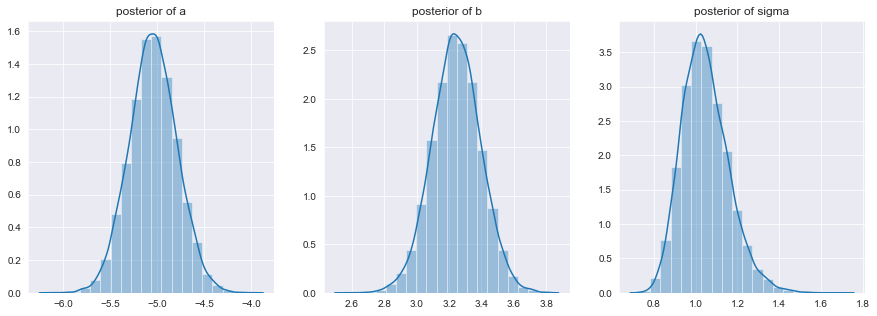

In [12]:
plt.figure(figsize=(15,5))
##aについて
plt.subplot(131)
sns.distplot(a_samples, bins=20)
plt.title("posterior of a")

##bについて
plt.subplot(132)
sns.distplot(b_samples, bins=20)
plt.title("posterior of b")

##sigmaについて
plt.subplot(133)
sns.distplot(sigma_samples, bins=20)
plt.title("posterior of sigma")

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

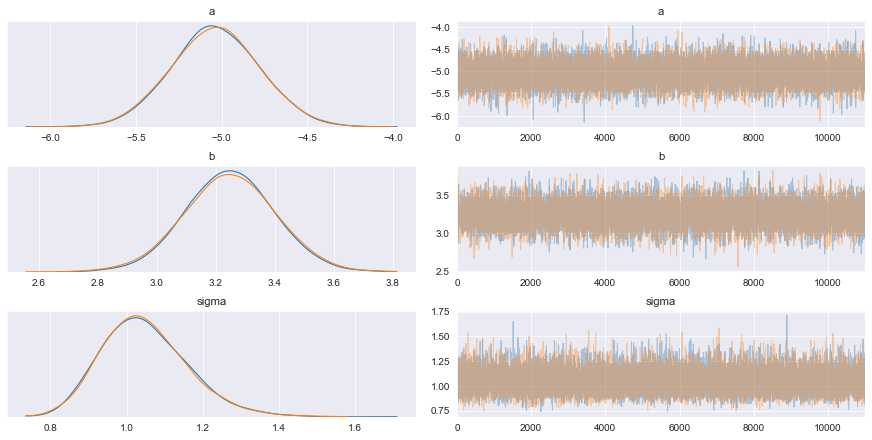

In [13]:
az.plot_trace(mcmc, var_names=["a", "b", "sigma"])

# PyMC3

In [14]:
import pymc3 as pm

In [15]:
time_start = time.time()

In [16]:
with pm.Model()as model_pymc3:
    a = pm.Normal("a", mu=0, sd=100)
    b = pm.Normal("b", mu=0, sd=100)
    sigma = pm.Lognormal("sigma", mu=0, sigma=10)
    
    y_pred = pm.Normal("y_pred", mu=a*x+b, sd=sigma, observed=y)

    #以下ボイラーコード
    # start = pm.find_MAP()
    # step = pm.Metropolis()
    # trace = pm.sample(11000, step, start)
    
    trace = pm.sample(11000)

Sampling 2 chains, 0 divergences: 100%|██████████| 23000/23000 [00:40<00:00, 566.06draws/s] 


In [17]:
print(time.time() - time_start)

59.58324313163757


In [18]:
map_estimate = pm.find_MAP(model=model_pymc3)
map_estimate

logp = -85.745, ||grad|| = 2.0104: 100%|██████████| 28/28 [00:00<00:00, 1386.91it/s]  


{'a': array(-5.04273107),
 'b': array(3.24366948),
 'sigma_log__': array(-0.00054563),
 'sigma': array(0.99945452)}

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

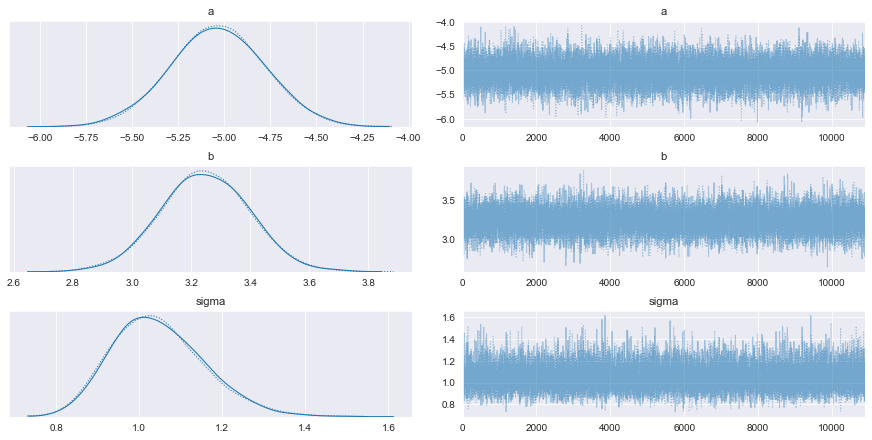

In [19]:
trace_n = trace[100:]
pm.traceplot(trace_n)